In [47]:
%matplotlib inline
from pandas import read_csv, DataFrame, get_dummies, Series
from numpy import nanmean
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from functools import partial
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from random import sample
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, VarianceThreshold

In [2]:
from warnings import simplefilter
simplefilter("ignore")

In [10]:
# Train data
train = read_csv('train.csv', na_values=-1)
print(train.head(2))

      PERID  IFATHER  NRCH17_2  IRHHSIZ2  IIHHSIZ2  IRKI17_2  IIKI17_2  \
0  25095143      4.0       2.0       4.0       1.0       3.0       1.0   
1  13005143      4.0       1.0       3.0       1.0       2.0       1.0   

   IRHH65_2  IIHH65_2  PRXRETRY    ...     TOOLONG  TROUBUND  PDEN10  COUTYP2  \
0       1.0       1.0      99.0    ...         1.0       2.0     1.0      1.0   
1       1.0       1.0      99.0    ...         2.0       2.0     2.0      3.0   

   MAIIN102  AIIND102     ANALWT_C    VESTR  VEREP  Criminal  
0       2.0       2.0  3884.805998  40026.0    1.0         0  
1       2.0       2.0  1627.108106  40015.0    2.0         1  

[2 rows x 72 columns]


In [11]:
train.drop('PERID', axis=1, inplace=True)
train = train.dropna()
train.columns.values

array(['IFATHER', 'NRCH17_2', 'IRHHSIZ2', 'IIHHSIZ2', 'IRKI17_2',
       'IIKI17_2', 'IRHH65_2', 'IIHH65_2', 'PRXRETRY', 'PRXYDATA',
       'MEDICARE', 'CAIDCHIP', 'CHAMPUS', 'PRVHLTIN', 'GRPHLTIN',
       'HLTINNOS', 'HLCNOTYR', 'HLCNOTMO', 'HLCLAST', 'HLLOSRSN',
       'HLNVCOST', 'HLNVOFFR', 'HLNVREF', 'HLNVNEED', 'HLNVSOR',
       'IRMCDCHP', 'IIMCDCHP', 'IRMEDICR', 'IIMEDICR', 'IRCHMPUS',
       'IICHMPUS', 'IRPRVHLT', 'IIPRVHLT', 'IROTHHLT', 'IIOTHHLT',
       'HLCALLFG', 'HLCALL99', 'ANYHLTI2', 'IRINSUR4', 'IIINSUR4',
       'OTHINS', 'CELLNOTCL', 'CELLWRKNG', 'IRFAMSOC', 'IIFAMSOC',
       'IRFAMSSI', 'IIFAMSSI', 'IRFSTAMP', 'IIFSTAMP', 'IRFAMPMT',
       'IIFAMPMT', 'IRFAMSVC', 'IIFAMSVC', 'IRWELMOS', 'IIWELMOS',
       'IRPINC3', 'IRFAMIN3', 'IIPINC3', 'IIFAMIN3', 'GOVTPROG',
       'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP2', 'MAIIN102',
       'AIIND102', 'ANALWT_C', 'VESTR', 'VEREP', 'Criminal'], dtype=object)

In [ ]:
# Normalization of Train and Test
cols = list(X.columns.values)

# Train
X = DataFrame(normalize(X))
X.columns = cols
X.head(2)

# Test
test_xgb_org = DataFrame(normalize(test_xgb_org))
test_xgb_org.columns = cols
test_xgb_org.head(2)

# Data Exploration and prepocessing

In [12]:
# Class imbalance
print('Target Class\n', train['Criminal'].value_counts())
cols = train.columns.values

# Number of unique values
print('\nNumber of unique values in each column')
for col in cols:
    print(col, len(train[col].unique()))

Target Class
 0    42233
1     3060
Name: Criminal, dtype: int64

Number of unique values in each column
IFATHER 4
NRCH17_2 4
IRHHSIZ2 6
IIHHSIZ2 1
IRKI17_2 4
IIKI17_2 2
IRHH65_2 3
IIHH65_2 3
PRXRETRY 5
PRXYDATA 6
MEDICARE 5
CAIDCHIP 5
CHAMPUS 5
PRVHLTIN 5
GRPHLTIN 7
HLTINNOS 5
HLCNOTYR 7
HLCNOTMO 17
HLCLAST 9
HLLOSRSN 17
HLNVCOST 6
HLNVOFFR 6
HLNVREF 6
HLNVNEED 6
HLNVSOR 6
IRMCDCHP 2
IIMCDCHP 2
IRMEDICR 2
IIMEDICR 2
IRCHMPUS 2
IICHMPUS 2
IRPRVHLT 2
IIPRVHLT 2
IROTHHLT 3
IIOTHHLT 3
HLCALLFG 2
HLCALL99 2
ANYHLTI2 5
IRINSUR4 2
IIINSUR4 2
OTHINS 2
CELLNOTCL 6
CELLWRKNG 6
IRFAMSOC 2
IIFAMSOC 2
IRFAMSSI 2
IIFAMSSI 2
IRFSTAMP 2
IIFSTAMP 2
IRFAMPMT 2
IIFAMPMT 2
IRFAMSVC 2
IIFAMSVC 2
IRWELMOS 13
IIWELMOS 3
IRPINC3 7
IRFAMIN3 7
IIPINC3 2
IIFAMIN3 2
GOVTPROG 2
POVERTY3 3
TOOLONG 3
TROUBUND 3
PDEN10 3
COUTYP2 3
MAIIN102 2
AIIND102 2
ANALWT_C 45250
VESTR 50
VEREP 2
Criminal 2


In [13]:
# Separate numerical and categorical columns
target = ['Criminal']
num_cols = ['NRCH17_2', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 'HLCNOTMO', 'HLCLAST', 'IRWELMOS', 'ANALWT_C']
cat_cols = [col for col in train.columns.values if col not in (num_cols + target)]

In [14]:
print(len(train.columns.values), len(num_cols), len(cat_cols))

71 8 62


In [15]:
# Converting to categorical and one hot encoding
for col in cat_cols:
    train[col] = train[col].astype('category',copy=False)
    temp = get_dummies(train[col])
    temp.columns = [col+'_'+str(i) for i in temp.columns]
    train = train.join(temp)
    train = train.drop(col,axis=1)
    print(col)

IFATHER
IIHHSIZ2
IIKI17_2
IIHH65_2
PRXRETRY
PRXYDATA
MEDICARE
CAIDCHIP
CHAMPUS
PRVHLTIN
GRPHLTIN
HLTINNOS
HLCNOTYR
HLLOSRSN
HLNVCOST
HLNVOFFR
HLNVREF
HLNVNEED
HLNVSOR
IRMCDCHP
IIMCDCHP
IRMEDICR
IIMEDICR
IRCHMPUS
IICHMPUS
IRPRVHLT
IIPRVHLT
IROTHHLT
IIOTHHLT
HLCALLFG
HLCALL99
ANYHLTI2
IRINSUR4
IIINSUR4
OTHINS
CELLNOTCL
CELLWRKNG
IRFAMSOC
IIFAMSOC
IRFAMSSI
IIFAMSSI
IRFSTAMP
IIFSTAMP
IRFAMPMT
IIFAMPMT
IRFAMSVC
IIFAMSVC
IIWELMOS
IRPINC3
IRFAMIN3
IIPINC3
IIFAMIN3
GOVTPROG
POVERTY3
TOOLONG
TROUBUND
PDEN10
COUTYP2
MAIIN102
AIIND102
VESTR
VEREP


In [16]:
train.head(2)

,NRCH17_2,IRHHSIZ2,IRKI17_2,IRHH65_2,HLCNOTMO,HLCLAST,IRWELMOS,ANALWT_C,Criminal,IFATHER_1.0,...,VESTR_40043.0,VESTR_40044.0,VESTR_40045.0,VESTR_40046.0,VESTR_40047.0,VESTR_40048.0,VESTR_40049.0,VESTR_40050.0,VEREP_1.0,VEREP_2.0
0,2.0,4.0,3.0,1.0,99.0,99.0,99.0,3884.805998,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,3.0,2.0,1.0,99.0,99.0,99.0,1627.108106,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Check for duplicate rows

In [17]:
# Missing value check
train.isnull().sum()

NRCH17_2         0
IRHHSIZ2         0
IRKI17_2         0
IRHH65_2         0
HLCNOTMO         0
HLCLAST          0
IRWELMOS         0
ANALWT_C         0
Criminal         0
IFATHER_1.0      0
IFATHER_2.0      0
IFATHER_3.0      0
IFATHER_4.0      0
IIHHSIZ2_1.0     0
IIKI17_2_1.0     0
IIKI17_2_3.0     0
IIHH65_2_1.0     0
IIHH65_2_2.0     0
IIHH65_2_3.0     0
PRXRETRY_2.0     0
PRXRETRY_94.0    0
PRXRETRY_97.0    0
PRXRETRY_98.0    0
PRXRETRY_99.0    0
PRXYDATA_1.0     0
PRXYDATA_2.0     0
PRXYDATA_94.0    0
PRXYDATA_97.0    0
PRXYDATA_98.0    0
PRXYDATA_99.0    0
                ..
VESTR_40023.0    0
VESTR_40024.0    0
VESTR_40025.0    0
VESTR_40026.0    0
VESTR_40027.0    0
VESTR_40028.0    0
VESTR_40029.0    0
VESTR_40030.0    0
VESTR_40031.0    0
VESTR_40032.0    0
VESTR_40033.0    0
VESTR_40034.0    0
VESTR_40035.0    0
VESTR_40036.0    0
VESTR_40037.0    0
VESTR_40038.0    0
VESTR_40039.0    0
VESTR_40040.0    0
VESTR_40041.0    0
VESTR_40042.0    0
VESTR_40043.0    0
VESTR_40044.

In [ ]:
# Outliers
fig, ax = plt.subplots(figsize=(15,  15))
# X_train.boxplot(by='target', ax=ax)

In [ ]:
# Bar plots
train.iloc[:, :4].hist()

In [ ]:
# Finding best distribution for each feature

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "beta",            #Beta
    "expon",           #Exponential
    "gamma",           #Gamma
    "laplace",         #Laplace
    "rayleigh",        #Rayleigh
    "uniform",         #Uniform
       ]

col_name=list(X_train.columns.values)
X_train.fillna(0, inplace=True)
trans = {}
for i in range(X_train.shape[1]):
    p_max = -100
    dist = ''
    temp = X_train[col_name[i]].transpose().values.tolist()
    # fit our data set against every probability distribution
    for cdf in cdfs:
        parameters = eval("stats."+cdf+".fit(temp)")
        #Applying the Kolmogorov-Smirnof one sided test
        D, p = stats.kstest(temp, cdf, args=parameters)
        if p > p_max:
            p_max = p
            dist = cdf
            #pretty-print the results
        #print cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D)
    #trans.append(dist)
    trans[col_name[i]]=dist
    print(col_name[i], ":", dist, "distribution")

# Feature Engineering / Selection

In [18]:
# Checking collinearity (using correlation)
correl = train.corr()
# train["feat_1"].corr(train["feat_2"])

In [21]:
cols = train.columns.values
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        curr_cor = correl.loc[cols[i], cols[j]]
        if (curr_cor >= 0.9) and (curr_cor < 1):
            print(cols[i], cols[j], curr_cor)

HLCLAST ANYHLTI2_1.0 0.952736990979
HLCLAST IRINSUR4_1.0 0.983634157935
IRWELMOS IIWELMOS_9.0 0.930461790315
PRXRETRY_94.0 PRXYDATA_94.0 0.968727905923
MEDICARE_1.0 IRMEDICR_1.0 0.99884859921
MEDICARE_2.0 IRMEDICR_2.0 0.973888851902
CAIDCHIP_1.0 IRMCDCHP_1.0 0.991166705492
CAIDCHIP_2.0 IRMCDCHP_2.0 0.983686307738
CHAMPUS_1.0 IRCHMPUS_1.0 0.999395499687
CHAMPUS_2.0 IRCHMPUS_2.0 0.971023194736
PRVHLTIN_1.0 IRPRVHLT_1.0 0.992883693158
PRVHLTIN_2.0 IRPRVHLT_2.0 0.993647810813
PRVHLTIN_94.0 GRPHLTIN_98.0 0.997962578379
PRVHLTIN_94.0 IIPRVHLT_3.0 0.918975704754
PRVHLTIN_97.0 GRPHLTIN_97.0 0.988012603095
GRPHLTIN_98.0 IIPRVHLT_3.0 0.920851868261
GRPHLTIN_99.0 IRPRVHLT_2.0 0.993647810813
HLTINNOS_1.0 IROTHHLT_1.0 0.987437950339
HLTINNOS_2.0 IROTHHLT_2.0 0.987218650281
HLTINNOS_2.0 IRINSUR4_2.0 0.987218650281
HLTINNOS_99.0 IROTHHLT_99.0 0.989203386892
HLTINNOS_99.0 IIOTHHLT_9.0 0.966687120457
HLCNOTYR_85.0 ANYHLTI2_98.0 0.976997630432
HLCNOTYR_97.0 HLLOSRSN_97.0 0.937813979994
HLCNOTYR_97.0 HLN

### Variance Threshold Check

In [22]:
vt = VarianceThreshold()
vt_train = vt.fit(train)

In [23]:
# vt.variances_
vt_df = DataFrame({'feature': list(train.columns.values), 'variance': vt.variances_}).sort_values(by='variance', ascending=True)
print(vt_df.tail(10))

        feature      variance
218  PDEN10_2.0  2.499113e-01
278   VEREP_2.0  2.499589e-01
277   VEREP_1.0  2.499589e-01
0      NRCH17_2  7.909803e-01
2      IRKI17_2  1.216136e+00
1      IRHHSIZ2  2.036199e+00
6      IRWELMOS  4.203853e+02
4      HLCNOTMO  5.899935e+02
5       HLCLAST  8.366619e+02
7      ANALWT_C  3.292275e+07


### Splitting data

In [70]:
y = train['Criminal']
X = train[[col for col in train.columns.values if col not in ['PERID', 'Criminal']]]
# X['download_time'].fillna(0, inplace=True)

In [71]:
# Splitting Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9, random_state=9)

### Normalization

In [72]:
# Normalizing data
norm_train = DataFrame(normalize(X_train))
norm_train.columns = list(X_train.columns.values)
norm_train.head(2)

,NRCH17_2,IRHHSIZ2,IRKI17_2,IRHH65_2,HLCNOTMO,HLCLAST,IRWELMOS,ANALWT_C,IFATHER_1.0,IFATHER_2.0,...,VESTR_40043.0,VESTR_40044.0,VESTR_40045.0,VESTR_40046.0,VESTR_40047.0,VESTR_40048.0,VESTR_40049.0,VESTR_40050.0,VEREP_1.0,VEREP_2.0
0,0.0,0.002499,0.000625,0.000625,0.061855,0.061855,0.061855,0.994229,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000625,0.0,0.0,0.000625,0.000000
1,0.0,0.002484,0.001242,0.001242,0.122972,0.122972,0.122972,0.977000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.001242


### PCA

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(norm_train.columns.values))

In [74]:
pca_train = DataFrame(pca.fit_transform(norm_train))

In [80]:
sum(pca.explained_variance_[:20])

0.030233344451452291

### Feature Importance

In [82]:
rf = ExtraTreeClassifier()#n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')

In [83]:
feat_imp = Series(rf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

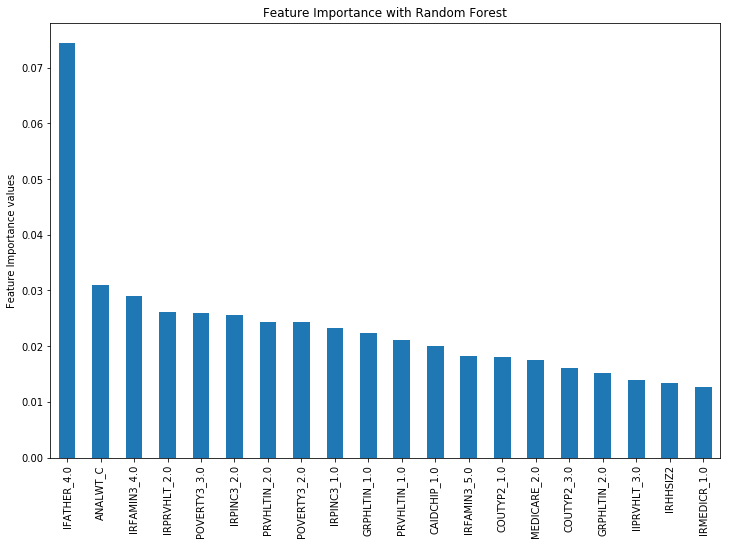

In [84]:
feat_imp[:20].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
#plt.subplots_adjust(bottom=0.25)
#plt.savefig('FeatImportance.png')
plt.show()

In [85]:
imp_feats = list(feat_imp[:20].index)
print(imp_feats)

['IFATHER_4.0', 'ANALWT_C', 'IRFAMIN3_4.0', 'IRPRVHLT_2.0', 'POVERTY3_3.0', 'IRPINC3_2.0', 'PRVHLTIN_2.0', 'POVERTY3_2.0', 'IRPINC3_1.0', 'GRPHLTIN_1.0', 'PRVHLTIN_1.0', 'CAIDCHIP_1.0', 'IRFAMIN3_5.0', 'COUTYP2_1.0', 'MEDICARE_2.0', 'COUTYP2_3.0', 'GRPHLTIN_2.0', 'IIPRVHLT_3.0', 'IRHHSIZ2', 'IRMEDICR_1.0']


### Feature Selection

In [86]:
# Select From Model
feats = list(X_train.columns.values)

rf = RandomForestClassifier(n_estimators=100, verbose=2, random_state=1, max_depth=20)

# define Boruta feature selection method
feat_selector = SelectFromModel(rf)

# find all relevant features - 20 features should be selected
feat_selector.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=2, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [87]:
sfmodel_feats = [feats[i] for i in feat_selector.get_support(indices=True)]
print(sfmodel_feats)

['NRCH17_2', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 'HLCNOTMO', 'IRWELMOS', 'ANALWT_C', 'IFATHER_1.0', 'IFATHER_2.0', 'IFATHER_4.0', 'PRXYDATA_1.0', 'PRXYDATA_99.0', 'MEDICARE_1.0', 'MEDICARE_2.0', 'CAIDCHIP_1.0', 'CAIDCHIP_2.0', 'PRVHLTIN_1.0', 'PRVHLTIN_2.0', 'GRPHLTIN_1.0', 'GRPHLTIN_2.0', 'GRPHLTIN_99.0', 'HLCNOTYR_2.0', 'IRMCDCHP_1.0', 'IRMCDCHP_2.0', 'IRMEDICR_1.0', 'IRMEDICR_2.0', 'IRPRVHLT_1.0', 'IRPRVHLT_2.0', 'OTHINS_1.0', 'OTHINS_2.0', 'CELLNOTCL_1.0', 'CELLNOTCL_2.0', 'IRFAMSOC_1.0', 'IRFAMSOC_2.0', 'IRFSTAMP_1.0', 'IRFSTAMP_2.0', 'IRPINC3_1.0', 'IRPINC3_2.0', 'IRPINC3_3.0', 'IRFAMIN3_1.0', 'IRFAMIN3_2.0', 'IRFAMIN3_3.0', 'IRFAMIN3_4.0', 'IRFAMIN3_5.0', 'IRFAMIN3_6.0', 'IRFAMIN3_7.0', 'IIFAMIN3_1.0', 'IIFAMIN3_3.0', 'GOVTPROG_1.0', 'GOVTPROG_2.0', 'POVERTY3_1.0', 'POVERTY3_2.0', 'POVERTY3_3.0', 'TOOLONG_1.0', 'TOOLONG_2.0', 'TROUBUND_1.0', 'PDEN10_1.0', 'PDEN10_2.0', 'PDEN10_3.0', 'COUTYP2_1.0', 'COUTYP2_2.0', 'COUTYP2_3.0', 'VESTR_40003.0', 'VESTR_40040.0', 'VESTR_40041.0', '

# Model Training

Random Forest

In [88]:
rf = RandomForestClassifier()
params = {'n_estimators': [1000, 2000],
         'max_depth': [8, 10, 14]}

grid = GridSearchCV(estimator=rf, param_grid=params, scoring=make_scorer(matthews_corrcoef))
grid.fit(X_train[imp_feats], y_train)

y_pred = grid.predict(X_test[imp_feats])
# print(y_pred[:4])

print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

MCC: 0.534068121059
Acc: 0.948900991071
Confusion Matrix
 [[37414   596]
 [ 1487  1267]]


### XGBoost

In [90]:
import xgboost as xgb

# Doing gridsearch to find best params configuration
clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

params = {
    'learning_rate': [0.01, 0.03],   # Learning rate alpha
    'max_depth': [8, 10, 14],   # maximum depth of the tree
    'gamma': [0.5, 1],   # minimum eval_score deduction at each split
    'min_child_weight': [6],  # minimum number of datapoints in a split
    'subsample': [0.9],  # sample size row-wise during bootstrap
    'colsample_bytree': [0.5],  # column-wise sample size
    'n_estimators': [1000],   # number of trees to build
    }

grid = GridSearchCV(clf, params, cv=5, verbose=20, n_jobs=-1, refit=True)

grid.fit(X_train[imp_feats], y_train)

# CV results
cv_result = DataFrame(grid.cv_results_).to_csv('cv_results.csv', index=False)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.4s
[Paralle

In [91]:
print(grid.best_score_)
print(grid.best_estimator_)

0.953852947671
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='error', gamma=1,
       learning_rate=0.03, max_delta_step=0, max_depth=14,
       min_child_weight=6, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)


In [92]:
# Testing on X_test
pred = grid.predict(X_test[imp_feats])
print('MCC:', matthews_corrcoef(y_test, y_pred))
print('Acc:', accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

MCC: 0.534068121059
Acc: 0.948900991071
Confusion Matrix
 [[37414   596]
 [ 1487  1267]]


In [64]:
# Using best params to find optimum number of iterations
grid_output = grid.best_params_
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'error', 
    'num_class': 2
    }

best_params = {**grid_output, **params}
#best_params['learning_rate'] = 0.02
print(best_params)

{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 1000, 'subsample': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'error', 'num_class': 2}


In [66]:
train_xgb = xgb.DMatrix(X_train[imp_feats], y_train)

cv_results = xgb.cv(best_params, train_xgb, num_boost_round=10000, nfold=5, stratified=True, as_pandas=True, 
                    seed=1, shuffle=True, early_stopping_rounds=20, verbose_eval=True)

XGBoostError: b'[23:27:25] D:\\Build\\xgboost\\xgboost-git\\src\\objective\\regression_obj.cc:101: Check failed: preds.size() == info.labels.size() (7244 vs. 3622) labels are not correctly providedpreds.size=7244, label.size=3622'

In [ ]:
nround = cv_results.shape[0]  # Where the best iteration happened
print('Best Iteration:', nround)
xgb_clf = xgb.train(best_params, train_xgb, num_boost_round=nround, verbose_eval=True)

# Predicting on the test set
test_xgb  = xgb.DMatrix(test_xgb_org)
test_pred = xgb_clf.predict(test_xgb)
Class_1, Class_2, Class_3, Class_4, Class_5, Class_6, Class_7, Class_8, Class_9 = map(list, zip(*test_pred))
output = DataFrame({'id': test['id'],
                    'Class_1': Class_1, 
                    'Class_2': Class_2, 
                    'Class_3': Class_3, 
                    'Class_4': Class_4, 
                    'Class_5': Class_5, 
                    'Class_6': Class_6, 
                    'Class_7': Class_7, 
                    'Class_8': Class_8, 
                    'Class_9': Class_9})
output = output[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']]

output.to_csv('output.csv', index=False)
output.head(2)